In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from ortools.linear_solver import pywraplp

%matplotlib inline
pd.set_option("display.max_rows", 500)

## Описание задачи

Мы работаем в Банке / Телеоператоре, у нашей компании есть клиенты, которые должны вносить платеж по кредиту / вносить абонентскую плату за услуги связи до фиксированной даты каждого месяца (например: до 20-го числа каждого месяца). Некоторые клиенты вносят оплаты заблоговременно, другие клиенты вносят оплаты в дату предполагаемой оплаты, некоторые забывают и вносят позже. Мы ожидаем, что клиенты будут вносить оплату вовремя, исходя из этой гипотезы, мы строим финансовую стратегию работы компании. Для улучшения ситуации, мы хотим информировать клиентов о приближающейся дате оплаты платежа / абоненской платы. При этом, у нас есть несколько способов коммуникации с клиентами: __SMS__, __звонок человека__, __IVR__ (звонок робота) или ничего не делать. При этом каждый вид взаимодействия стоит нам определенных денег, и у нас есть ограничение на количество способов взаимодействия каждым способом. __Например__, если в Call-центре компании работает 100 сотрудников, каждый из которых может совершить 30 звонков в день, то более 3000 звонков в день мы сделать не можем. Или, есть у нас есть бюджет 100.000 рублей на отправку SMS-коммуникации, то при стоимости одного SMS - 2 рубля, мы не можем отправить более 50.000 SMS-сообщений в день. И так далее. __ЦЕЛЬ__ состоит в том, чтобы оптимизировать коммуникацию с клиентами, то есть максимизировать долю клиентов, которые исполняют свои обязанности вовремя, при этом затратив на это минимальное количество средств.

__План решения__ состоит из трех основных этапов:
* построить ML-модели для оценки вероятности внесения платежа при коммуникации указанным способом;
* оценить финансовый эффект от взаимодействия указанным способом;
* назначить каждому клиенту 1 вид взаимодействия для максимизации указанных в описании задачи метрик.

__Данные__:
для решения такой задачи, нам нужны данные, из которых была бы понятна эффективность каждого конкретного метода взаимодействия. Для сбора таких данных можно поступить следующим образом: выбрать небольшую часть репрезентативной выборки клиентов, и каждому клиенту случайным образом, назначать вид коммуникации с соблюдением заданных ограничений на количество доступных звонков / бюджет на SMS / и т.д. После завершение эксперимента, у нас будут данные для обучения модели. 

In [3]:
data = pd.read_csv("train.csv")
test = pd.read_csv("valid.csv")

data.head(n=2)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,COMMUNICATION_TYPE
0,176207,0,Cash loans,M,Y,N,0,135000.0,450000.0,27193.5,...,0,0,0,1.0,0.0,0.0,0.0,0.0,1.0,PUSH
1,425123,0,Cash loans,F,N,Y,1,193500.0,295668.0,11277.0,...,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0,SMS


In [4]:
gp = data[["COMMUNICATION_TYPE", "TARGET"]]
gp_stats = gp.groupby(["COMMUNICATION_TYPE"]).agg({"TARGET": ["count", "mean", "sum"]})
gp_stats.columns = ["OBSERVERS", "EVENTRATE", "EVENTS"]
gp_stats = gp_stats.reset_index()

gp_stats

,COMMUNICATION_TYPE,OBSERVERS,EVENTRATE,EVENTS
0,CALL,3439,0.078802,271
1,IVR,7185,0.067084,482
2,None,3336,0.056055,187
3,PUSH,126096,0.085586,10792
4,SMS,44450,0.071001,3156


## 1. Обучение моделей

Обучим 5 моделей для оценки вероятности НЕ внесения платежа при заданном типе коммуникации

In [5]:
numerical_features = data.select_dtypes(exclude=["object"]).columns.tolist() + ["COMMUNICATION_TYPE"]
X, y = data[numerical_features].drop(["SK_ID_CURR", "TARGET"], axis=1), data["TARGET"]

In [6]:
x_train, x_test = train_test_split(
    X, train_size=0.7, random_state=1
)
y_train, y_test = train_test_split(
    y, train_size=0.7, random_state=1
)

In [7]:
def fit_model(X: pd.DataFrame,
              y: pd.Series,
              communication_type: str,
              estimator,
              fillna=-9999
              ):
    """
    Обучение модели под отдельный вид коммуникации.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для обучения модели.

    y: pandas.core.frame.Series, shape = [n_samples, 1]
        Вектор целевой переменной для обучения модели.

    communication_type: str
        Вид коммуникации: "CALL", "IVR", "SMS", "PUSH", "None".

    estimator: sklearn.callable
        Объект Estimator, поддерживающий API sklearn.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    model: sklearn.callable
        Объект обученной модели.

    """
    mask = X["COMMUNICATION_TYPE"] == communication_type
    x_train = X.drop("COMMUNICATION_TYPE", axis=1)
    x_train, y_train = x_train.loc[mask], y.loc[mask]

    print("x_train.shape = {} rows, {} cols".format(*x_train.shape))
    model = estimator.fit(x_train.fillna(fillna), y_train)

    return model


def evaluate_model(X: pd.DataFrame,
                   y: pd.Series,
                   communication_type: str,
                   estimator,
                   fillna=-9999
                   ) -> float:
    """
    Оценка качества модели с помощью метрики ROC-AUC.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для оценки модели.

    y: pandas.core.frame.Series, shape = [n_samples, 1]
        Вектор целевой переменной для оценки модели.

    communication_type: str
        Вид коммуникации: "CALL", "IVR", "SMS", "PUSH", "None".

    estimator: sklearn.callable
        Объект Estimator, к которому был применен метод fit.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    score: float
        Значение метрики ROC-AUC.

    """
    check_is_fitted(estimator)

    mask = X["COMMUNICATION_TYPE"] == communication_type
    x_test = X.drop("COMMUNICATION_TYPE", axis=1)
    x_test, y_test = x_test.loc[mask], y.loc[mask]

    y_pred = estimator.predict_proba(x_test.fillna(fillna))
    score = roc_auc_score(y_test, y_pred[:, 1])

    return score

In [8]:
models = {}

params = {
    "n_estimators": 250,
    "max_depth": 3,
    "random_state": 27,
    "n_jobs": 6
}

for comm_type in ["CALL", "SMS", "PUSH", "IVR", "None"]:

    model = fit_model(
        X=x_train,
        y=y_train,
        communication_type=comm_type,
        estimator=RandomForestClassifier(**params)
    )
    models[f"{comm_type}_model"] = model

x_train.shape = 2413 rows, 104 cols
x_train.shape = 30988 rows, 104 cols
x_train.shape = 88400 rows, 104 cols
x_train.shape = 4984 rows, 104 cols
x_train.shape = 2369 rows, 104 cols


In [9]:
# Оценка качества модели

for comm_type in ["CALL", "SMS", "PUSH", "IVR", "None"]:
    model = models[f"{comm_type}_model"]
    score = evaluate_model(
        X=x_test,
        y=y_test,
        communication_type=comm_type,
        estimator=model
    )
    print(f"Communication: {comm_type}, Score: {score}")

Communication: CALL, Score: 0.6925881649731023
Communication: SMS, Score: 0.7049007879884858
Communication: PUSH, Score: 0.712898552813245
Communication: IVR, Score: 0.6935033020023978
Communication: None, Score: 0.6552424113676061


## 2. Применение моделей к тестовому набору данных

Применим все построенные модели к тестовым данным, таким образом, мы получим вероятность дефолта (не внесения платежа) при коммуникации указанным способом. После чего, умножим вероятность дефолта на сумму платежа, таким образом мы получим математическое ожидание потерь при взаимодействии каждым способом. Наша задача минимизировать ожидаемые потери или максимизировать ожидаемую сумму поступающих платежей. Это одно и то же.

In [10]:
def create_predictions(models: dict, X: pd.DataFrame, fillna=-9999) -> pd.DataFrame:
    """
    Применение семейства моделей к набору данных X.

    Parameters
    ----------
    models: Dict[estimator]
        Словарь с экземплярами обученных моделей.

    X: pandas.core.frame.DataFrame, shape = [n_samples, n_features]
        Матрица признаков для применения модели.

    fillna: int/float, optional, default = -9999
        Значение для заполнение пропусков в матрице признаков.
        Опциональный параметр, по умолчанию, равен -9999.

    Returns
    -------
    y_pred: pandas.core.frame.DataFrame, shape = [n_samples, len(models)]
        Матрица с прогнозами всех моделей.

    """
    y_pred = pd.DataFrame()
    for model in models:
        estimator = models[model]
        score = estimator.predict_proba(X.fillna(fillna))[:, 1]
        name = model.split("_")[0]
        y_pred[f"{name}_SCORE"] = score

    return y_pred

def calculate_expected_losses(scores: pd.DataFrame, X: pd.DataFrame) -> pd.DataFrame:
    """
    Вычисление матрицы ожидаемых потерь при взаимодействии
    каждым способом. Вычисляется как произведение вероятности
    дефолта на величину платежа.

    Parameters
    ----------
    scores: pandas.core.frame.DataFrame
        Матрица вероятностей дефолта.

    X: pandas.core.frame.DataFrame
        Матрица признаков для применения модели.

    Returns
    -------
    losses: pandas.core.frame.DataFrame
        Матрица ожидаемых потерь.

    """
    scores["SK_ID_CURR"] = X["SK_ID_CURR"]
    scores["AMT_ANNUITY"] = X["AMT_ANNUITY"]
    scores_columns = [col for col in scores.columns if "SCORE" in col]

    for score in scores_columns:
        name = score.split("_")[0]
        name = f"EXPECTED_LOSS_{name}"

        scores[name] = scores["AMT_ANNUITY"] * scores[score]

    return scores

In [11]:
x_test, y_test = test[x_train.columns], test["TARGET"]
x_test = x_test.drop("COMMUNICATION_TYPE", axis=1)

In [12]:
y_pred_test = create_predictions(models, x_test)
y_pred_test = calculate_expected_losses(y_pred_test, test)

## Визуализируем данные для понимания распределений

[]

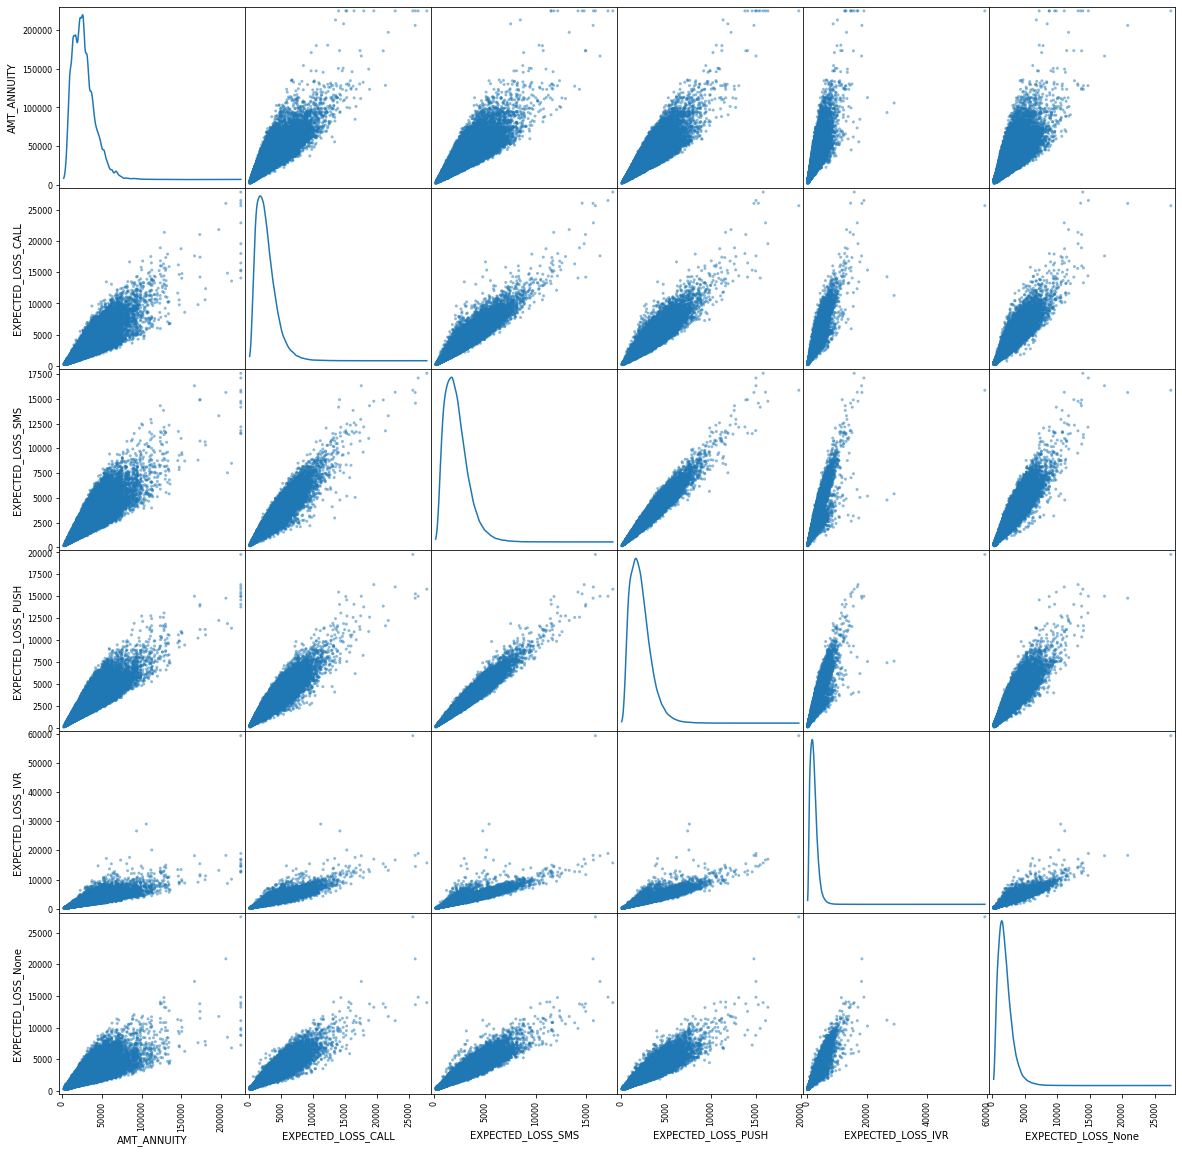

In [13]:
figsize = (20, 20)

cols_to_plot = [
    "AMT_ANNUITY",
    "EXPECTED_LOSS_CALL",
    "EXPECTED_LOSS_SMS",
    "EXPECTED_LOSS_PUSH",
    "EXPECTED_LOSS_IVR",
    "EXPECTED_LOSS_None"
]

scatter_matrix(
    frame=y_pred_test[cols_to_plot],
    figsize=figsize,
    diagonal="kde"
)
plt.plot()

## 3. Оптимизация типа взаимодействия

Предположим, что стоимость взаимодействия __CALL__ - 5 рубля, взаимодействия типа __IVR__ - 3 рубля, __SMS__ - 1.5 рубля, __PUSH__ - 1 рубль, взимодействие типа __NONE__ - 0 рублей. Бюджет на все виды взаимодействия - 100000 рублей. Пусть мы можем сделать 1000 звонков, 10000 IVR, 15000 сообщений, 42500 вывести PUSH в мобильном приложении.

Создадим функцию, которая опишет модель данных:
* `weights`: вектор, содержащий веса (прогнозируемые потери).
* `values`: вектор, содержащий значения элементов (стоимость взаимодействия).
* `bin_capacities`: вектор, содержащий максимальное количество каждого взаимодействия


In [41]:
def create_data_model(y_pred_df: pd.DataFrame) -> dict:
    """
    Создание модели данных для оптимизации.

    Parameters
    ----------
    y_pred_df: pandas.core.frame.DataFrame
        Датафрейм со значениями прогнозируемых потерь
        при каждом типе взаимодействия.

    Returns
    -------
    data: dict
        Словарь с описанием модели данных.

    """
    data = {}
    
    weights = np.array([
        [5 for i in range(y_pred_df.shape[0])],
        [3 for i in range(y_pred_df.shape[0])],
        [1.5 for i in range(y_pred_df.shape[0])],
        [1 for i in range(y_pred_df.shape[0])],
        [1 for i in range(y_pred_df.shape[0])],
        ])
    weights = weights.flatten()
    
    values = np.array([
        y_pred_df["EXPECTED_LOSS_CALL"].values,
        y_pred_df["EXPECTED_LOSS_IVR"].values,
        y_pred_df["EXPECTED_LOSS_SMS"].values,
        y_pred_df["EXPECTED_LOSS_PUSH"].values,
        y_pred_df["EXPECTED_LOSS_None"].values,
    ])
    values = values.flatten()

    data['weights'] = weights
    data['values'] = values
    data['items'] = list(range(len(weights)))
    data['num_items'] = len(weights)
    num_bins = 5
    data['bins'] = list(range(num_bins))
    data['bin_capacities'] = [
        int(0.008*y_pred_df.shape[0]),
        int(0.0812975082313727*y_pred_df.shape[0]),
        int(0.12194626234705906*y_pred_df.shape[0]),
        int(0.345514409983334*y_pred_df.shape[0])]
    data['bin_capacities'].append(y_pred_df.shape[0] - np.sum(data['bin_capacities']))
    print(data["bin_capacities"])
    return data

In [42]:
# Объявим оптимизатор.
np.random.seed(27)

solver = pywraplp.Solver(
    'multiple_knapsack_mip',
    pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING
)

y_pred_sample = y_pred_test.sample(1000)
data_model = create_data_model(y_pred_sample)

[8, 81, 121, 345, 445]


Каждый `x[(i, j)]` - это бинарная переменная 0-1, где `i` - конкретный клиент, а `j` - способ взаимодействия. В решении `x[(i, j)]` будет 1, если клиенту `i` назачено взаимодействие `j`, и 0 в противном случае.

In [43]:
x = {}
for i in data_model['items']:
    for j in data_model['bins']:
        x[(i, j)] = solver.IntVar(0, 1, 'x_%i_%i' % (i, j))

__Ограничения следующие:__

Каждому клиенту можету быть назначен только один тип взаимодействия (только один способ коммуникации). Это ограничение устанавливается, требуя, чтобы сумма `x[i][j]` по всем ячейкам `j` была меньше или равна 1.
Общий вес всей корзины (всех клиентов для данного взаимодействия), не может превышать вместимость корзины (максимально количество взаимодействия указанного типа). Это ограничение устанавливается тем, что сумма весов предметов, помещенных в корзину `j`, должна быть меньше или равна емкости корзины.

In [44]:
for i in data_model['items']:
    solver.Add(sum(x[i, j] for j in data_model['bins']) <= 1)

for j in data_model['bins']:
    solver.Add(
        sum(x[(i, j)] * data_model['weights'][i]
            for i in data_model['items']) <= data_model['bin_capacities'][j])

Следующий код определяет целевую функцию для задачи.

In [45]:
objective = solver.Objective()

for i in data_model['items']:
    for j in data_model['bins']:
        objective.SetCoefficient(x[(i, j)], data_model['values'][i])

Будем максимизировать функцию, чтобы ожидаемые потери (ожидаемый дефолт) был минимальным.

In [46]:
objective.SetMaximization()

Для каждого вида взаимодействия в коде отображаются клиенты (индекс в исходном датафрейме), а также общая стоимость и общий вес для каждого вида взаимодействия.

In [47]:
status = solver.Solve()
if status == pywraplp.Solver.OPTIMAL:
    print('Total packed value:', objective.Value())
    total_weight = 0
    for j in data_model['bins']:
        bin_weight = 0
        bin_value = 0
        print('Bin ', j, '\n')
        for i in data_model['items']:
            if x[i, j].solution_value() > 0:
                print('Item', i, '- weight:', data_model['weights'][i], ' value:',
                      data_model['values'][i])
                bin_weight += data_model['weights'][i]
                bin_value += data_model['values'][i]
        print('Packed bin weight:', bin_weight)
        print('Packed bin value:', bin_value)
        print()
        total_weight += bin_weight
    print('Total packed weight:', total_weight)
else:
    print('The problem does not have an optimal solution.')

Total packed value: 3270298.347823246
Bin  0 

Item 3033 - weight: 1.0  value: 2310.6731025240265
Item 3318 - weight: 1.0  value: 2959.974994686092
Item 3513 - weight: 1.0  value: 2361.584130599262
Item 3665 - weight: 1.0  value: 2463.654340455427
Item 3873 - weight: 1.0  value: 2286.4374811092684
Item 3886 - weight: 1.0  value: 2781.0208900523685
Item 4023 - weight: 1.0  value: 2591.768219024903
Item 4828 - weight: 1.0  value: 2411.7588579582402
Packed bin weight: 8.0
Packed bin value: 20166.872016409587

Bin  1 

Item 2154 - weight: 1.5  value: 7561.8584574115475
Item 2166 - weight: 1.5  value: 3579.454649398819
Item 2195 - weight: 1.5  value: 5268.68465044818
Item 2474 - weight: 1.5  value: 4041.446409175129
Item 2501 - weight: 1.5  value: 3881.7944099729552
Item 2737 - weight: 1.5  value: 4429.928649368142
Item 2982 - weight: 1.5  value: 3960.54929010646
Item 2994 - weight: 1.5  value: 6802.3179758420265
Item 3036 - weight: 1.0  value: 2340.7121976695266
Item 3062 - weight: 1.0  va

Item 3713 - weight: 1.0  value: 3327.2716743362216
Item 3714 - weight: 1.0  value: 2364.510863754851
Item 3722 - weight: 1.0  value: 2885.933464478876
Item 3728 - weight: 1.0  value: 3204.047439536623
Item 3729 - weight: 1.0  value: 6081.13239411634
Item 3735 - weight: 1.0  value: 2674.704353571514
Item 3737 - weight: 1.0  value: 4028.4210357304905
Item 3748 - weight: 1.0  value: 2348.5634128432694
Item 3750 - weight: 1.0  value: 2878.2443237841335
Item 3755 - weight: 1.0  value: 2862.191603605419
Item 3762 - weight: 1.0  value: 3980.274135419756
Item 3788 - weight: 1.0  value: 3539.3620001118106
Item 3794 - weight: 1.0  value: 8485.3587762181
Item 3795 - weight: 1.0  value: 3529.1451213732594
Item 3805 - weight: 1.0  value: 3008.529158474853
Item 3810 - weight: 1.0  value: 4404.939923853001
Item 3813 - weight: 1.0  value: 3927.006720259011
Item 3850 - weight: 1.0  value: 2863.8190788355287
Item 3879 - weight: 1.0  value: 2760.982143680158
Item 3885 - weight: 1.0  value: 10207.58094027

Item 3084 - weight: 1.0  value: 2522.1442781423075
Item 3085 - weight: 1.0  value: 3011.875581973343
Item 3088 - weight: 1.0  value: 5529.395275358046
Item 3096 - weight: 1.0  value: 3265.534336617108
Item 3106 - weight: 1.0  value: 3321.8694437930462
Item 3110 - weight: 1.0  value: 3479.7091118104795
Item 3113 - weight: 1.0  value: 2942.360446556339
Item 3118 - weight: 1.0  value: 3213.9346306722655
Item 3145 - weight: 1.0  value: 2885.3232737557782
Item 3149 - weight: 1.0  value: 3216.5508575388635
Item 3151 - weight: 1.0  value: 4932.205649579282
Item 3152 - weight: 1.0  value: 3023.377005474755
Item 3153 - weight: 1.0  value: 2892.500984982529
Item 3159 - weight: 1.0  value: 6245.216471044649
Item 3165 - weight: 1.0  value: 2817.317086286328
Item 3176 - weight: 1.0  value: 3234.268125520382
Item 3190 - weight: 1.0  value: 3162.60279175282
Item 3195 - weight: 1.0  value: 5489.9567387451425
Item 3197 - weight: 1.0  value: 2443.3459335679436
Item 3198 - weight: 1.0  value: 2809.705932